X-point coordinates: R = 1.4382030382221238, Z = -0.9380769698447726
psi at the X-point: psi = 0.19472143605814185


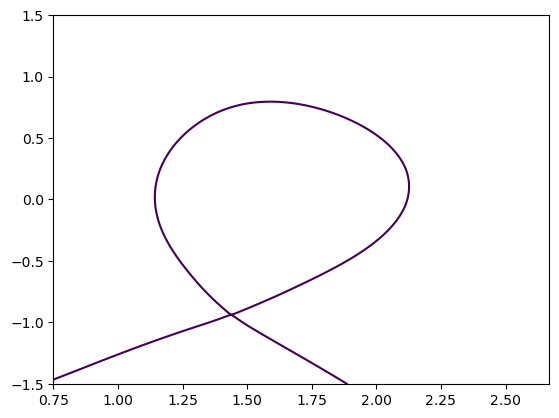

In [136]:
#same script as gemtraceranalysis.py only with higher grid resolution

import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.fft as fft
from scipy.stats import norm
from collections import defaultdict
from scipy.ndimage import sobel
from scipy.interpolate import interp1d
from scipy.interpolate import RectBivariateSpline
from scipy.optimize import curve_fit
from scipy.optimize import minimize

# Load Needed Data

psi_a  = 0.0
orbits = np.loadtxt('./out/tracer.out')
R      = np.loadtxt('./R.dat')
Z      = np.loadtxt('./Z.dat')
psi    = np.loadtxt('./psi_p.dat')
Br     = np.loadtxt('./BR.dat')
Bz     = np.loadtxt('./Bz.dat')
#rlim   = np.loadtxt('./rlim.dat')
#zlim   = np.loadtxt('./zlim.dat')
#rbou   = np.loadtxt('./rbou.dat')
#zbou   = np.loadtxt('./zbou.dat')
u2     = './initialv_par'
eng    = './energeez'

# Find the index where zlim is closest to zero
#flip_index = np.argmin(np.abs(zlim))
#flip_bou   = np.argmin(np.abs(zbou))

# Flip the arrays about the line zlim == 0
#flipped_rlim = np.concatenate((rlim[:flip_index], rlim[flip_index:][::-1]))
#flipped_zlim = np.concatenate((-zlim[:flip_index], -zlim[flip_index:][::-1]))
#flipped_rbou = np.concatenate((rbou[:flip_bou], rbou[flip_bou:][::-1]))
#flipped_zbou = np.concatenate((-zbou[:flip_bou], -zbou[flip_bou:][::-1]))

for i in range (1,9999999):
    if orbits[i,1] <= orbits[i-1,1]:
        break
number_of_particles=i

with open(u2, 'r') as u2f:
    lines = u2f.readlines()
    u2m = []
    for line in lines:
        line_elements = line.split()
        for ele in range(len(line_elements)):
            u2m.append(float(line_elements[ele]))

with open(eng, 'r') as engf:
    linesf = engf.readlines()
    engm = []
    for linef in linesf:
        line_elementsf = linef.split()
        for elef in range(len(line_elementsf)):
            engm.append(float(line_elementsf[elef]))

# Set Divertor
# Linear Div. setup
div_size=np.linspace(0,200,201)
r_1,r_2=1.5436,1.71  #1.23,1.48
z_1,z_2=-1.28075,-1.128  #-1.4,-1.2
m=(z_2-z_1)/(r_2-r_1)
b=z_1-m*r_1
x_val=[r_1,r_2]
y_val=[m * x + b for x in x_val]

#TODO: Set up more realistic divertor. Check eqdsk documentation for divertor position and shape.

# Set Variables
divpsi  = []
lamhist = []
delpsi  = []
energy  = []
R_i_div = []
R_i_mid = []
gpmid   = []
gpdiv   = []
parlos  = []
timest  = []

#Physical Constants#############################################################################################
m_i = 2*1.67*10**(-27) #Deuterium Mass
Z_i = 1.6*10**(-19) #Fundamental Charge
T_i = 0.387954*1000*Z_i #Ion Temp in keV
T_e = 0.073468*1000*Z_i #Ele Temp in keV
cs  = np.sqrt(T_i+T_e/m_i) #Speed of sound
vT  = np.sqrt(T_i/m_i) #Thermal velocity
################################################################################################################

# Calculate the gradients of the poloidal flux function
eq_psi_rz=-psi+np.max(psi)
dpsi_dR = sobel(eq_psi_rz, axis=1) / (R[-1] - R[0])
dpsi_dZ = sobel(eq_psi_rz, axis=0) / (Z[-1] - Z[0])

# Interpolate the gradients
dpsi_dR_interp = RectBivariateSpline(Z, R, dpsi_dR)
dpsi_dZ_interp = RectBivariateSpline(Z, R, dpsi_dZ)

# Define a function to compute the gradient magnitude at a given point (R, Z)
def gradient_magnitude(point):
    dR, dZ = dpsi_dR_interp(point[1], point[0]), dpsi_dZ_interp(point[1], point[0])
    return np.sqrt(dR**2 + dZ**2)[0, 0]  # Take the first element of the array
    
# Define an objective function to minimize the gradient magnitude
def objective_function(point):
    return gradient_magnitude(point)

# Reorder function for future calculations
def reorder_arrays(array1, array2):
    indexed_array1 = [(array1[i], i) for i in range(len(array1))]
    indexed_array1.sort(key=lambda x: x[0])
    reordered_array1 = [indexed_array1[i][0] for i in range(len(array1))]
    reordered_array2 = [array2[indexed_array1[i][1]] for i in range(len(array1))]
    
    return reordered_array2
    
# Find the X-point by minimizing the gradient magnitude
# You can initialize the search for the minimum with a rough estimate of the X-point location
initial_guess = (1.3, -1.2)  # Adjust this value based on your specific case
bounds = [(1.3, 1.5), (-1.1, -0.8)]  # Set the bounds for the search
result = minimize(objective_function, initial_guess, bounds=bounds, method='L-BFGS-B')

R_x, Z_x      = result.x
R_idx = np.abs(R - R_x).argmin()
Z_idx = np.abs(Z - Z_x).argmin()
    
# Obtain psi value at the X-point
psi_at_xpoint = eq_psi_rz[Z_idx, R_idx]
print(f"X-point coordinates: R = {R_x}, Z = {Z_x}")
print(f"psi at the X-point: psi = {psi_at_xpoint}")

#Extract R,Z Parameterization for lcfs
contour = plt.contour(R,Z,eq_psi_rz, levels=[psi_at_xpoint])
    




Number of particles that hit divertor: 604
SOL width at divertor: lambda = 0.005172221650245153 m
SOL width at midplane: lambda = 0.0016651395710482887 m


ValueError: max() arg is an empty sequence

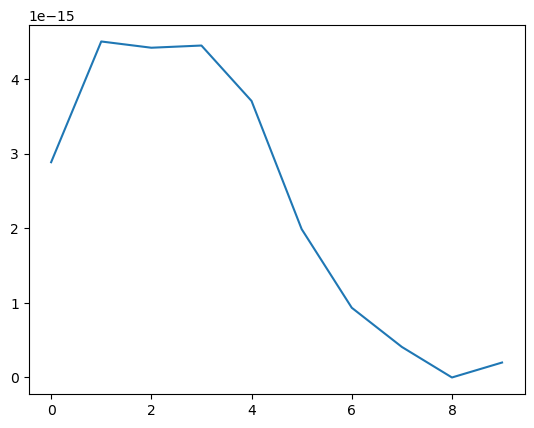

In [206]:
from scipy.interpolate import RegularGridInterpolator
psi_p= np.transpose(psi)
dR = R[1]-R[0]
dZ = Z[1]-Z[0]
Rg,Zg =np.meshgrid(R,Z)

m_idx_z = (np.argmin(abs(Z)))

[dpdr,dpdz] = np.gradient(psi_p,dR,dZ)

gradpsi = np.sqrt(dpdr**2+dpdz**2)

f = RegularGridInterpolator((R, Z), psi_p)
g = RegularGridInterpolator((R, Z), gradpsi)

##find R_mid##################################################################################
idx_z = np.where(Z==0)
#print (m_idx_z[0][0])
#m_idx_z= idx_z[0][0]
for i in range (len(R)//2,len(R)):
    if (psi_p[i-1][m_idx_z]-psi_a)*(psi_p[i][m_idx_z]-psi_a)<=0:
        R_m_a=R[i-1]*(abs(psi_p[i][m_idx_z]-psi_a)+R[i]*abs(psi_p[i-1][m_idx_z]-psi_a))/abs(psi_p[i][m_idx_z]-psi_p[i-1][m_idx_z])
        gradpsim = gradpsi[i-1][m_idx_z]*(abs(psi_p[i][m_idx_z]-psi_a)+gradpsi[i][m_idx_z]*abs(psi_p[i-1][m_idx_z]-psi_a))/abs(psi_p[i][m_idx_z]-psi_p[i-1][m_idx_z])
        break
#print(R_m_a,gradpsim)

##find intercetion of divertor plate and psi_a####################################
startp=[r_1,z_1]
endp=[r_2,z_2]
[divertor]=[np.linspace([r_1,z_1],[r_2,z_2],400)]#,np.linspace(z_1,z_2,200)]

#print (f(divertor))
inter = divertor[np.argmin(abs(f(divertor)-psi_a))]

gradpsid = g(inter)[0]
#print (gradpsid)

#######################################################################################
# MUST MANUALLY SET END TIME
start_time_step = 1
end_time_step   = 10000
#######################################################################################

delpsi=[]
R_i_div=[]
R_i_mid=[]
energy=[]
gpmid=[]
gpdiv=[]

time = np.linspace(start_time_step,end_time_step,end_time_step-1)

#gradpsid=0.225023
#gradpsim=0.7620


#plt.figure(figsize=(5, 9))
#plt.contour(R,Z,psi,50,alpha=0.15)
#if (psi!=[]):
#    print("111")
for particle_ID in range (0,number_of_particles-1):   ###here choose the particles you want to plot
    start=(start_time_step-1)*number_of_particles+particle_ID
    end=(end_time_step-1)*number_of_particles+particle_ID

    #plt.plot(orbits[start:end:number_of_particles,2],orbits[start:end:number_of_particles,3])
    
    xloc  = orbits[start:end:number_of_particles,2]
    yloc  = orbits[start:end:number_of_particles,3]
    poi   = (m*xloc + b - yloc)
    inrz  = np.argmin(poi)
#    Rv    = np.argmin(abs(Rhuge-xloc[inrz]))
#    Zv    = np.argmin(abs(Zhuge-yloc[inrz]))
#######################################################################################################################################    
    indices = np.where(poi>0)
    #print (indices)
    if (len(indices[0])>0):# and indices[0][0] != 0):
#        print (len(indices[0]))
        x    = xloc[indices[0][0]]
        z    = yloc[indices[0][0]]
    
        i   = int((x-R[0])/(R[1]-R[0]))
        wx0 = (i+1)-(x-R[0])/(R[1]-R[0])
        wx1 = 1.0-wx0

        j   = int((z-Z[0])/(Z[1]-Z[0]))
        wz0 = (j+1)-(z-Z[0])/(Z[1]-Z[0])
        wz1 = 1-wz0
#        print (x,z,psi_p[i,j],i,j)
        
        p_psi = wx0*wz0*psi_p[i,j]+wx1*wz0*psi_p[i+1,j]+wx0*wz1*psi_p[i,j+1]+wx1*wz1*psi_p[i+1,j+1]
#        print (f"ID={particle_ID}, psi={p_psi},x={x},R_x={R_x}")

        if p_psi < psi_a and x > R_x:
            d_psi = p_psi - psi_a
            delpsi.append(d_psi)
            R_i_div.append(x)
            R_i_mid.append(R_m_a+abs(d_psi/gradpsim))
            energy.append(engm[particle_ID])
            gpmid.append(gradpsim)
            gpdiv.append(gradpsid)

#######################################################################################################################################    
    


#    if abs(m*xloc[inrz] - yloc[inrz] + b) < 0.05 and xloc[inrz] >= Rhuge[Rdiv-int(newsize*0.03)] and xloc[inrz] <= Rhuge[Rdiv+int(newsize*0.25)]:
#        divpsi.append(newpsi[Zv][Rv])
#        parlos.append(1)
#        timest.append(inrz)
#        rpm   = np.argmin(abs(newpsi[Zv][Rv]-newpsi[zhugemid][Rv:])) + Rv #new grid coordinate
#        gpmid.append(np.sqrt(dpsidr[zhugemid][rpm]**2 + dpsidz[zhugemid][rpm]**2)) #new grid gradient
#        gpdiv.append(np.sqrt(dpsidr[Zv][Rv]**2 + dpsidz[Zv][Rv]**2)) #old grid gradient
#    #    plt.scatter(Rhuge[rpm],Zhuge[zhugemid])
#        energy.append(engm[particle_ID])
#        R_i_div.append(xloc[inrz])
#        R_i_mid.append(Rhuge[rpm])
        #plt.scatter(Rhuge[Rv],Zhuge[Zv])

#Calculate grad psi
#gradpsim    = np.sqrt(dpsidr[zmid,rmid]**2 + dpsidz[zmid,rmid]**2)
#gradpsid    = np.sqrt(dpsidr[Zdiv,Rdiv]**2 + dpsidz[Zdiv,Rdiv]**2)

#Calculate SOL width
#for smasher in range(len(divpsi)):
#    delpsi.append(divpsi[smasher]-newpsi[Zdiv][Rdiv])
#    lamhist.append(abs((divpsi[smasher]-newpsi[Zdiv][Rdiv])/gradpsid))
#print(np.sum(delpsi)/len(delpsi))
lamqdiv    = abs(np.sum(delpsi)/len(delpsi))/gradpsid
lamqmid    = abs(np.sum(delpsi)/len(delpsi))/gradpsim

print(f"Number of particles that hit divertor: {len(delpsi)}")
print(f"SOL width at divertor: lambda = {lamqdiv} m")
print(f"SOL width at midplane: lambda = {lamqmid} m")


#Heat Flux calculations
q_mid = []
q_jun = []
Rar   = []
engs  = []
Ridiv     = reorder_arrays(R_i_div, R_i_div)
Rimid     = reorder_arrays(R_i_div,R_i_mid)
ordenergy = reorder_arrays(R_i_div, energy)
gpmidd    = reorder_arrays(R_i_div, gpmid)
gpdivv    = reorder_arrays(R_i_div, gpdiv)
engs      = np.cumsum(ordenergy)
#print(Ridiv)
# Calder/Zhichen Derivation: q = \frac{1}{2\pi R_i} \frac{|\nabla \psi_{mid,i}|}{|\nabla \psi_{div,i}|} \frac{\partial E_s}{\partial R}
#Junyi Derivation: q = \frac{\sum_i E_{s,i}}{2\pi(\Delta R_i)R_i}
#for ri in range(len(Ridiv)):
#    q_div = (gpmidd[ri]/gpdivv[ri])*np.gradient(engs,abs(Rhuge[1]-Rhuge[0]))[ri]/(2*np.pi*Ridiv[ri])
#    q_jun.append(ordenergy[ri]/(2*np.pi*Ridiv[ri]*abs(Ridiv[i]-Ridiv[i-1])))
    #q_jun.append(engs[ri]/(2*np.pi*Rimid[ri]*abs(R[1]-R[0]))*lamqmid)
    #q_mid.append(q_div)
#    Rar.append((Rimid[ri] - Rhuge[rmid])*1000)

#print (Ridiv)

number_of_beams = 10
#########################################################################################################################3
Rgrid_div=np.linspace(Ridiv[0],Ridiv[-1],number_of_beams,endpoint=True)
q_div = np.zeros(number_of_beams)
#dR_div = (Ridiv[-1] - Ridiv[0])/12
#print (Rgrid_div)
for i in range (0,len(Ridiv)):
    j = int((Ridiv[i]-Ridiv[0])/(Rgrid_div[1]-Rgrid_div[0]))
#    print (j)

    q_div[j] = q_div[j]+ordenergy[i]/Ridiv[i]
    
##########################################################################################################################
#print(ordenergy)
plt.plot (q_div)
plt.show

sums = defaultdict(int)
for set_number, points in zip(Rar, q_mid):
    sums[set_number] += points

s_0  = []
qpar = []
for key, value in sums.items():
     s_0.append(key)
     qpar.append(value)
qpar = reorder_arrays(s_0,qpar)
s_0  = reorder_arrays(s_0,s_0)

sumj = defaultdict(int)
for set_numberj, pointsj in zip(Rar, q_jun):
    sumj[set_numberj] += pointsj
qjun = []
for keyj, valuej in sumj.items():
    qjun.append(valuej)
qjun = reorder_arrays(s_0,qjun)

#Eich Fit calculation
def eichfunc(sval,q_0,S,q_bg):
    q_s  = []
    lam = lamqmid*1000
    for erro in range(len(sval)):
        erfc = math.erfc((S/(2*lam))-(sval[erro]/S))
        expo = np.exp((S/(2*lam))**2-(sval[erro]/lam))
        q_s.append((q_0/2)*expo*erfc + q_bg)
    return q_s

#Add zeros to end for flattening
for zed in range(0,5):
    s_0.append(max(s_0)+1)
    qpar.append(0)
    qjun.append(0)

popt, pcov   = curve_fit(eichfunc, s_0, qpar,maxfev=100000)
poptj, pcovj = curve_fit(eichfunc, s_0, qjun,maxfev=100000)#, p0=popt)
print(f"params CZ == {popt}")
print(f"params JN == {poptj}")

plt.plot(x_val,y_val,color='black',linewidth=3.0)
plt.plot(flipped_rlim,flipped_zlim,color='orange',linewidth=3.0)
plt.plot(flipped_rbou,flipped_zbou,color='red')
#plt.plot(rlim,zlim,color='orange')
plt.contour(R,Z,eq_psi_rz,levels=[psi_at_xpoint])

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Tracer particle orbits', fontsize=15)
plt.xlabel('R(m)', fontsize=20)
plt.ylabel('Z(m)',fontsize=20)
plt.axis('scaled')
plt.xlim(min(R), max(R))
plt.ylim(min(Z), max(Z))
plt.show()

#Particle Loss Plot
time          = reorder_arrays(timest,timest)
lostp         = reorder_arrays(timest,parlos)
lostparticles = np.cumsum(lostp)

plt.figure()
plt.plot(time,lostparticles,linewidth=3.0)
plt.xticks(fontsize=5)
plt.yticks(fontsize=15)
plt.title(f'Number of Particles Hitting Divertor $\\simeq {(len(lostp)*100)/number_of_particles} \\%$')
plt.xlabel('timestep', fontsize=20)
plt.ylabel('Number of Particles', fontsize=20)
plt.ylim(0, 10000)
plt.grid()
plt.tight_layout()
plt.show()

#Plot Initial Velocity Distribution
mu, std = norm.fit(u2m/vT) 

xmin = np.min(u2m/vT)-1
xmax = np.max(u2m/vT)+1
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
 
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.hist(u2m/vT, bins=50, alpha=0.6,color='b')
ax2.plot(x, p, '--r', linewidth=2)
ax1.set_xlabel('$v_{\\parallel}/v_T$', fontsize=20)
ax1.set_ylabel('Number of Particles', color='b', fontsize = 15)
ax2.set_ylabel('Distribution', color='r', fontsize = 15)
plt.title('Initial $v_{\\parallel}/v_T$ Distribution', fontsize=15)
plt.show()

#Plot Distribution of lambda_q
plt.figure()
plt.hist(lamhist,40)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('$\\lambda$ Distribution', fontsize=15)
plt.xlabel('$\\lambda$ at Divertor', fontsize=20)
plt.ylabel('Number of Particles',fontsize=20)
plt.show()

qpfit = eichfunc(s_0,*popt)
# try:
#     if 'poptj' in globals() and isinstance(poptj, np.ndarray):
#         qjfit = eichfunc(s_0, *poptj)
#         qjun = np.array(qjun) * np.max(qpar) / np.max(qjun)
#         qjfit = np.array(qjfit) * np.max(qpfit) / np.max(qjfit)
#     else:
#         print("poptj is not defined or is not an np.ndarray")
# except NameError:
#     # Handle NameError in case 'poptj' is not defined at all
#     print("poptj is not defined")
qjfit = eichfunc(s_0,*poptj)
# qjun = np.array(qjun) * np.max(qpar)/np.max(qjun)

#Plot heat flux distribution
print(f"Number of bins: {len(s_0)}")
plt.figure()
# plt.plot(s_0,qpar,marker='s',color='orange',linestyle='dashed',label='CST')
plt.plot(s_0,qjun/max(qjun),marker='o',color='orange',linestyle='dashed',label='CST')
# plt.plot(s_0,qpfit,color = 'red',label='Eich Fit 1')
plt.plot(s_0,qjfit/max(qjun),color='red',label='Eich Fit')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.title('Heat Flux', fontsize=15)
plt.xlabel('$s-s_0$ [mm]', fontsize=20)
plt.ylabel('q [A.U.]',fontsize=20)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()